## Metric Reconstruction  
Chapter 10. 3D Reconstruction of Cameras and Structure



In [2]:
import matplotlib.image as mplimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import glob
from utils import *
%matplotlib notebook

In [ ]:
def rectifyMetricF(imA, nLinePairs, doRotationAfterH = True, doTranslationAfterH = True, doScalingAfterH = True):
    # --------- Supporting functions -----------
    # Plot image and lines
    def replotMetric(imA,limits,lines=[[],[]],x=[[],[]],y=[[],[]]):
        plt.close() # ginput does not allow new points to be plotted
        plt.imshow(imA,cmap='gray')
        plt.axis('image')

        # Plot settings 
        plot_lines = False
        plot_points = True
        
        # Determine how many lines to plot in red, leaving the last in green if the second needs to be picked
        nl1 = len(y[0])
        nl2 = len(y[1])
        if nl1 == nl2:
            nred = nl1
        else:
            nred = nl1 - 1
        if plot_lines:
            for k in range(nred):
                xx,yy = getPlotBoundsLine(limits, lines[0][k])
                plt.plot(xx,yy,'r--')
            if nl1 - nred > 0:
                xx,yy = getPlotBoundsLine(limits, lines[0][nl-1])
                plt.plot(xx,yy,'g--')
            for l in lines[1]:
                xx,yy = getPlotBoundsLine(limits, l)
                plt.plot(xx,yy,'b--')
        if plot_points:
            # Plot lines: direction 1, all red but the last one green
            for k in range(0,nred):
                plt.plot(x[0][k],y[0][k],'r-')
            if nl1 - nred > 0:
                plt.plot(x[0][nl1-1],y[0][nl1-1],'g-')
            # Plot lines: direction 2
            for k in range(0,len(y[1])):
                plt.plot(x[1][k],y[1][k],'b-')
        plt.axis('off')
        plt.axis('image')
        plt.draw()


    # m = list of lines
    # l = list of lines orthogonal to lines in m
    #
    # Return S = AA', where A is the affine part of the transformation
    def linesToS(l, m, scale_opt=0):
        if len(l) != len(m):
            raise Exception("lenl: %d, len(m): %d", len(l), len(m))
        nlines = len(l)

        if scale_opt == 1:
            # Solve for S = [s11 s21  s21 s22], then scale by 1/max(S)
            A = np.zeros((len(l), 3))
            for r in range(0,len(l)):
                A[r,0] = l[r][0]*m[r][0]
                A[r,1] = l[r][0]*m[r][1] + l[r][1]*m[r][0]
                A[r,2] = l[r][1]*m[r][1]

            s = smallestSingularVector(A) 
            S = np.array([[s[0], s[1]], [s[1], s[2]]]).reshape((2,2))
            S = S / max(s[0],s[2])
        else:
            # Solve for S = [s11 s21  s21 1]
            RHS = np.zeros((nlines,1))
            A = np.zeros((nlines, 2))
            for k in range(0,nlines):
                RHS[k] = -l[k][1]*m[k][1]
            for k in range(0,nlines):
                A[k,0] = l[k][0]*m[k][0]
                A[k,1] = l[k][0]*m[k][1] + l[k][1]*m[k][0]
            s = np.linalg.lstsq(A,RHS)[0]
            S = np.array([[s[0][0], s[1][0]],[s[1][0],1]])
        return S

    # -------------- START -----------------
    
    # Create figure
    fig1 = plt.figure()
    spd = False
    while not spd:
        replotMetric(imA,imA.shape)
        
        # Lines
        lines = [[],[]] # lines[i][j][k] contains the line for the i'th direction (0,1), j'th selected line, k'th coordinate (0,1,2)
        x = [[],[]]     # x[i][j][k] contains x coordinate for the i'th direction (0,1), j'th selected line, k'th (0,1) selected point
        y = [[],[]]     # y[i][j][k] contains y coordinate for the i'th direction (0,1), j'th selected line, k'th (0,1) selected point

        # Get line pairs interactively
        for i in range(0,2*nLinePairs):
            ii = i % 2
            if ii == 1:
                plt.suptitle('Click two points intersecting a line perpendicular to the green line')
            else:
                if i == 0:
                    plt.suptitle('Click two points intersecting the first of two perpendicular lines')
                else:
                    plt.suptitle('Click two points intersecting the first of two perpendicular lines not parallel to any in the first set')
            x1,y1,line = getLine()
            x[ii].append(x1)
            y[ii].append(y1)
            lines[ii].append(line)
            # re-plot figure
            replotMetric(imA,imA.shape,lines,x,y)

        # Form S = KK'
        S = linesToS(lines[0], lines[1])

        # lprime = H^-T l
        u,s,vh = sp.linalg.svd(S,full_matrices=1,compute_uv=1)
            
        try: # FIXME
            A = np.linalg.cholesky(S)
            spd = True;
        except np.linalg.linalg.LinAlgError:
            w = np.linalg.eig(S)
            print('S was not SPD, try again...')
            print("S = ")
            print(S)
            print("eigenvalues: ")
            print(w)
            continue;

    # form H from A
    H = np.zeros((3,3))
    H[0:2,0:2] = A
    H[2,2] = 1
    print("H:")
    print(H)
    Hinv = np.linalg.inv(H)
    if False: # not the best way to set the scaling
        Hinv = Hinv / max(Hinv[0:2,0:2].flatten(1))
        print("Hinv:")
        print(Hinv)
        Hinv[2,2] = 1
        print("-> Hinv:")
        print(Hinv)

    # Rotate to make linesTr0 parallel to either [0 1 0] or [1 0 0]  
    # i.e.  (HR^-T * linesTr0) = [0 C D]^T, any D
    # Note HR^-T = HR
    # r1 * linesTr0 = 0
    if doRotationAfterH:
        Hinv = rotateHToLine(Hinv, lines[0][0])
     
    # Translate to keep Hx > 0
    if doTranslationAfterH:
        Hinv = translateHToPosQuadrant(Hinv, imA.shape)

    # Scale to keep the output contained just within the image matrix
    if doScalingAfterH:
        Hinv = scaleHToImage(Hinv, imA.shape, False)
  
    # Do rectification
    imRect = myApplyH(imA, Hinv)

    # Clean up
    plt.close(fig1)

    # Return rectified image
    return imRect, Hinv

In [3]:
IMG_DIR = '/home/seonwookim/Projects/GIST-ADIP/data/'

In [4]:
images = [each for each in glob.glob(IMG_DIR + "Kakao*.jpg")]

In [5]:
im = mplimg.imread(images[0])

In [6]:
im2 = mplimg.imread(images[1])

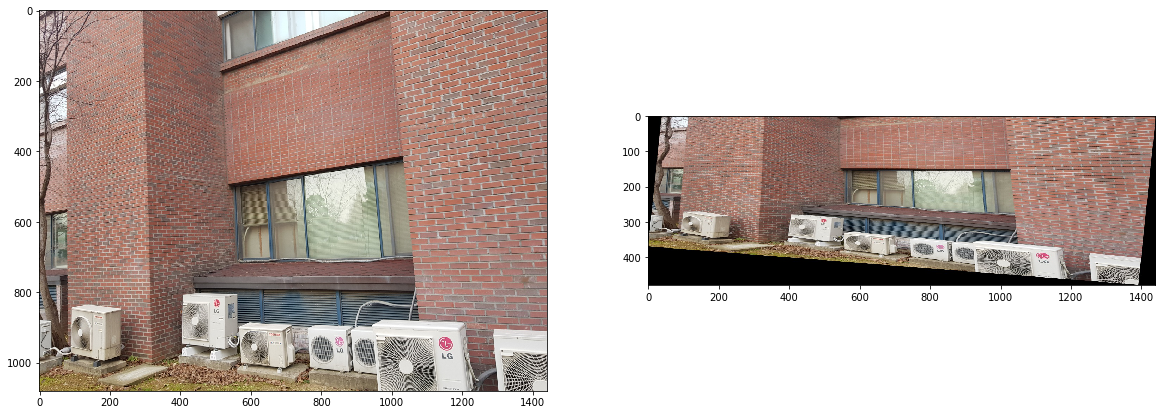

In [7]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(im)

plt.subplot(122)
plt.imshow(im2)
plt.show()

In [8]:
nLinePairs = 2

In [ ]:
imA, HA = rectifyAffineF(im, nLinePairs)

/home/seonwookim/.conda/envs/adip/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [1]:
import matplotlib.image as mplimg
import os
import sys
from utils import *

In [7]:
nLinePairs = 2

In [ ]:
imgPath = sys.argv[1];
fileparts = os.path.splitext(imgPath)
if fileparts[1] == '':
    fileparts = (fileparts[0], '.png')
imgPath = fileparts[0] + fileparts[1];
im = mplimg.imread(imgPath)

In [ ]:
imA, HA = rectifyAffineF(im, nLinePairs)

/home/seonwookim/.conda/envs/adip/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [ ]:
im = mpli